Optimize bin size based on MCMC with Travis' ages

In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import emcee

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [2]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand

In [3]:
import time
from tqdm import trange
# get average ages
def getAveAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in range(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
            #mask = mask & (paras[:,j]>=checkpara[j]-binfs[j]/2)
            #mask = mask & (paras[:,j]<=checkpara[j]+binfs[j]/2)
        
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['kin_age']=v_to_age(kin_age,p_mr)
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err

    

In [4]:
import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in range(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['kin_age']=v_to_age(kin_age,p_mr)

    

In [5]:
# define MCMC functions

def log_likelihood(theta):
    getkinAges(df_prot_s,['teff_calc','Prot_log','logg_y','abs_G'],theta)
    stat_df=df_prot_s.loc[df_prot_s['iso_age']<10]
    stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
    if len(stat_df)==0:
        return -np.inf
    chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
    chisq_ave=(chisq_sing/len(stat_df))
    return -0.5*chisq_ave

def log_prior(theta):
    teff,Prot,logg,absg=theta
    if 0<teff<500 and 0<Prot<5 and 0<logg<5 and 0<absg<5:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp=log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll=log_likelihood(theta)
    if not np.isfinite(ll):
        return -np.inf
    return lp+ll



In [6]:
df_prot_s=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')
df_rvar_s=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

df_prot_p=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin_pc.pkl')
df_rvar_p=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin_pc.pkl')


df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')

merg1=['KID','age','Rvar','Prot','teff_calc','Prot_log','logg_y','v_b','w','abs_G']
merg2=['KID','age','Rvar','teff_calc','Rvar_log','logg','v_b','abs_G']
df_prot_s=pd.merge(df_isoages,df_prot_s[merg1],left_on='KIC',right_on='KID',how='inner')
df_rvar_s=pd.merge(df_isoages,df_rvar_s[merg2],left_on='KIC',right_on='KID',how='inner')
df_prot_s=df_prot_s.dropna(subset=['age','iso_age'])
df_rvar_s=df_rvar_s.dropna(subset=['age','iso_age'])

#df_prot_s=df_prot_s.loc[df_prot_s['iso_age']<10]
#df_prot_s=df_prot_s.loc[df_prot_s['iso_age_err1']<3]
#df_prot_s=df_prot_s.loc[abs(df_prot_s['iso_age_err2'])<3]
df_prot_s['iso_age_err']=np.sqrt(df_prot_s['iso_age_err1']**2.+df_prot_s['iso_age_err2']**2.)

df_prot_p=pd.merge(df_isoages,df_prot_p[merg1],left_on='KIC',right_on='KID',how='inner')
df_rvar_p=pd.merge(df_isoages,df_rvar_p[merg2],left_on='KIC',right_on='KID',how='inner')
df_prot_p=df_prot_p.dropna(subset=['age','iso_age'])
df_rvar_p=df_rvar_p.dropna(subset=['age','iso_age'])


In [19]:
pos=[366.6666666666667, 2.0, 0.55,0.01]+1e-4 * np.random.randn(10, 4)
nwalkers, ndim = pos.shape

print(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 1000, progress=True);



10 4


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
100%|██████████| 1000/1000 [17:08:23<00:00, 61.70s/it]  


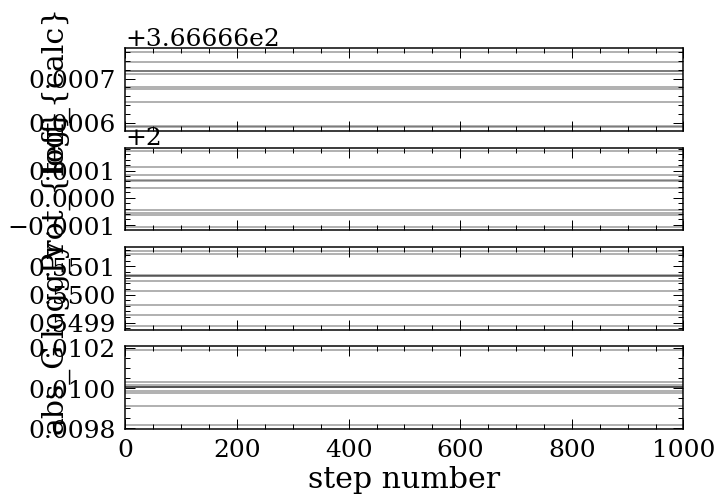

In [20]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['teff_{calc}','Prot_{log}','logg_y','abs_G']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
print(flat_samples.shape)

(660, 4)


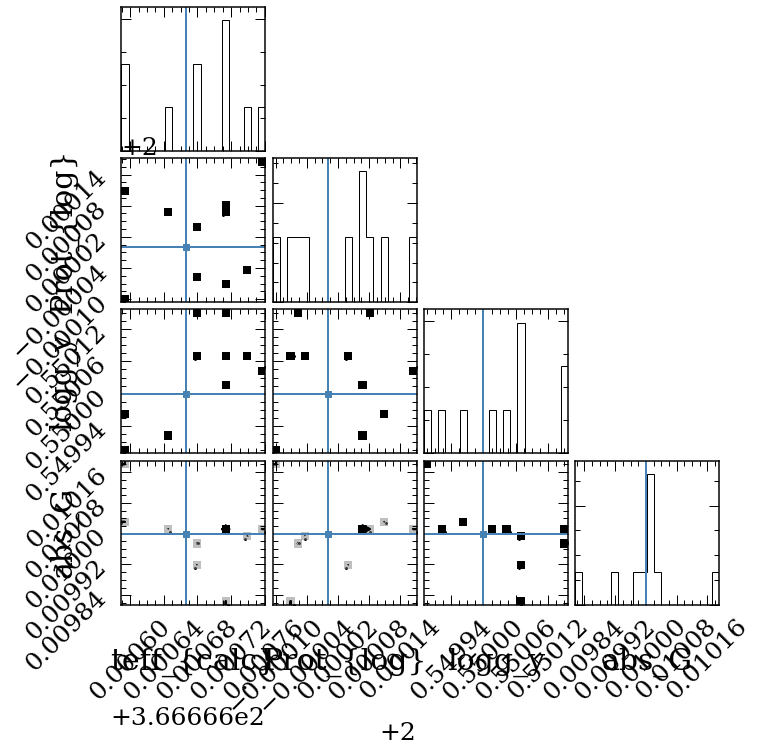

In [22]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[366.6666666666667, 2.0, 0.55,0.01]
);

In [23]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>